In [1]:
# Libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Load data
def load_data(stock_name, start, end):
    data = pd.read_csv('/Users/ruben/Documents/Machine Learning/project/CAC40_stocks_2010_2021.csv')
    data = data[data['StockName'] == stock_name]
    # In the dataset, the type of the column "Data" is string. So here, for convenience, I convert its type to Date.
    data['Date'] = pd.to_datetime(data['Date'])
    con1 = data['Date'] >= start
    con2 = data['Date'] < end
    data = data[con1 & con2]
    return data

In [3]:
stock_name = 'FTI'
data = load_data(stock_name, start=dt.datetime(2012, 1, 1), end=dt.datetime(2020, 1, 1))
# print(data.head(5))
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [4]:
# How many days I want to base the predictions on
days = 60

x_train = []
y_train = []

for x in range(days, len(scaled_data)):
    x_train.append(scaled_data[x - days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
# Model
def lstm_model():
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))

    return model

In [6]:
# Train
model = lstm_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

# Save weights for best model
checkpointer = ModelCheckpoint(filepath='/Users/ruben/Documents/Machine Learning/project/weights_best.hdf5', verbose=2,
                               save_best_only=True)

model.fit(x_train, y_train, epochs=25, batch_size=64, callbacks=[checkpointer])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [7]:
# Test model
test_data = load_data(stock_name, start=dt.datetime(2020, 1, 2), end=dt.datetime(2021, 1, 1))
actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []
y_test = []
for x in range(days, len(model_inputs)):
    x_test.append(model_inputs[x-days:x, 0])
    y_test.append(model_inputs[x, 0])


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))
y_test = np.array(y_test)

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

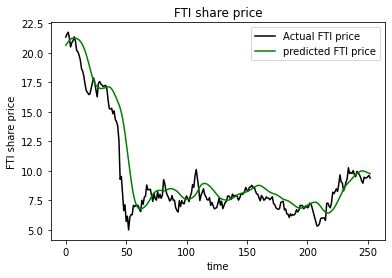

In [8]:
# Plot
plt.plot(actual_prices, color='black', label=f"Actual {stock_name} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {stock_name} price")
plt.title(f"{stock_name} share price")
plt.xlabel("time")
plt.ylabel(f"{stock_name} share price")
plt.legend()
plt.show()

In [12]:
# Evaluation
print("MSE=", model.evaluate(x_test, y_test))

253/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================